In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [293]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [294]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [295]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [296]:
len(dataset)

68

In [297]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 2, 1, 0, 2, 0, 1, 2, 0, 2])>>


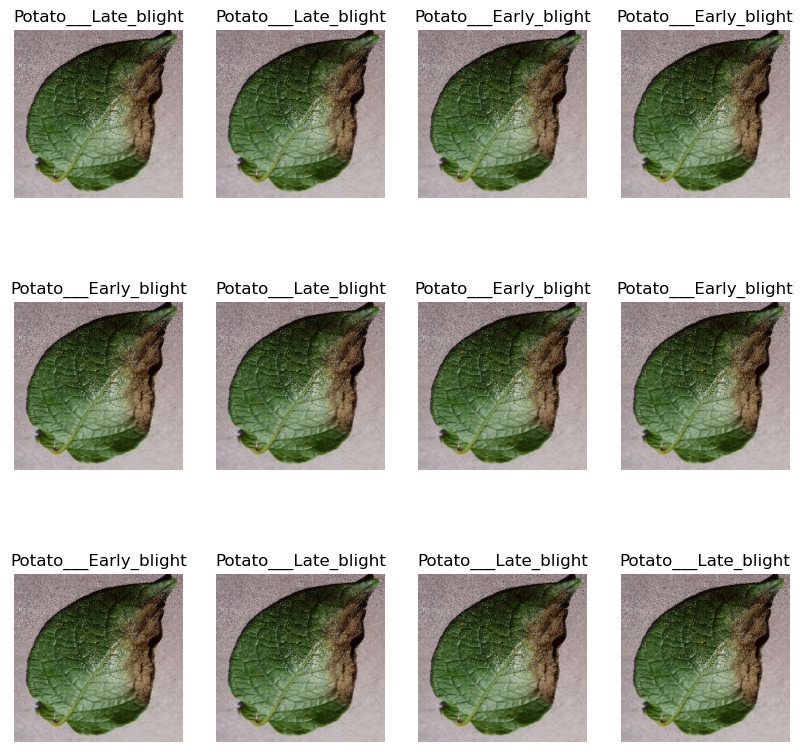

In [298]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> 10% validation, 10% test

In [299]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [300]:
train_ds= dataset.take(54)
len(train_ds)

54

In [301]:
train_ds = dataset.skip(54)
len(train_ds)

14

In [302]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [303]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [304]:
test_ds = train_ds.skip(6)
len(test_ds)

8

In [305]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [306]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [307]:
len(train_ds)

54

In [308]:
len(val_ds)

6

In [309]:
len(test_ds)

8

In [310]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [311]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [312]:
data_augmentation = tf.keras.Sequential ([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [313]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(63, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [314]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_39 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_40 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_141 (Conv2D)         (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_141 (MaxPooli  (32, 127, 127, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_142 (Conv2D)         (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_142 (MaxPooli  (32, 62, 62, 64)         0         
 ng2D)                                               

In [315]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

We store the training data in a tensorflow element called history that allows us to access the values of our models accuracy per epoch so that we can visually plot the training model and see the trends in the data.

In [326]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 246s 5s/step - loss: 0.0471 - accuracy: 0.9826 - val_loss: 0.0426 - val_accuracy: 0.9844
Epoch 2/50
54/54 [==============================] - 227s 4s/step - loss: 0.0651 - accuracy: 0.9815 - val_loss: 0.0237 - val_accuracy: 0.9896
Epoch 3/50
54/54 [==============================] - 231s 4s/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.0220 - val_accuracy: 0.9896
Epoch 4/50
54/54 [==============================] - 231s 4s/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.2021 - val_accuracy: 0.9375
Epoch 5/50
54/54 [==============================] - 233s 4s/step - loss: 0.0212 - accuracy: 0.9925 - val_loss: 0.0874 - val_accuracy: 0.9635
Epoch 6/50
54/54 [==============================] - 230s 4s/step - loss: 0.0190 - accuracy: 0.9925 - val_loss: 0.0840 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 230s 4s/step - loss: 0.0173 - accuracy: 0.9931 - val_loss: 0.0408 - val_accuracy: 0.9844
Epoch 8/50
54

KeyboardInterrupt: 

scores = model.evaluate(test_ds) this is a python data structure that stores th e models accuracy and loss

In [317]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 15s 1s/step - loss: 0.1237 - accuracy: 0.9375


In [318]:
scores

[0.12366794794797897, 0.9375]

In [319]:
history

In [320]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [321]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [322]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

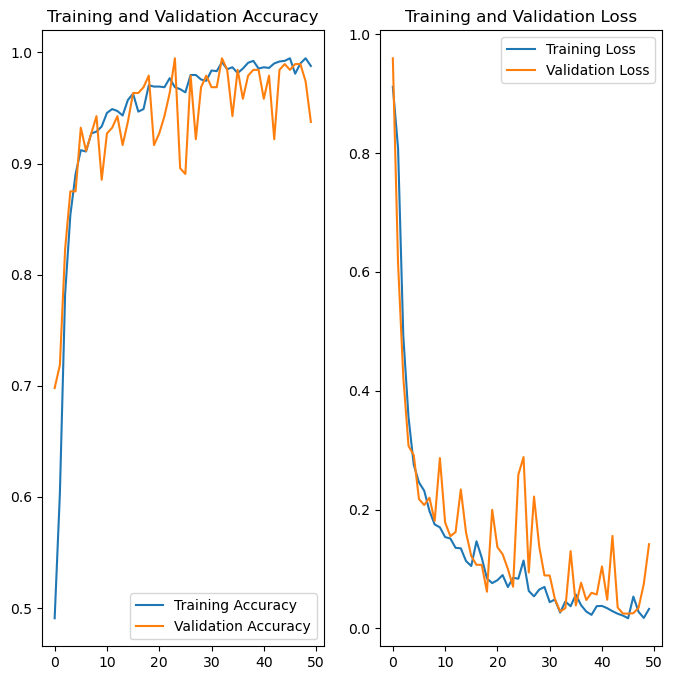

In [323]:
from datetime import datetime
batch = str(BATCH_SIZE)
epoch = str(EPOCHS)
filename = datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '_batch-' + batch + '_' + '_epoch-' + epoch + '.png'
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(filename)
plt.show()

first_image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Late_blight


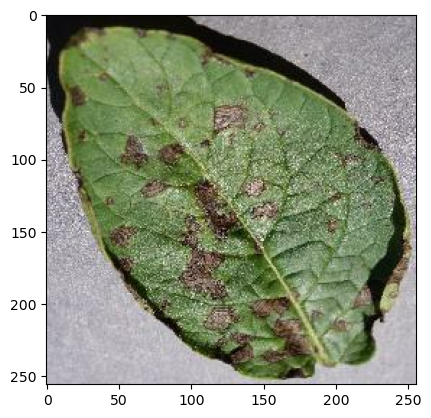

In [324]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first_image to predict")
    plt.imshow(first_image)
    print("actual label:" ,class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:" ,class_names[np.argmax(batch_prediction[12])])

In [325]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array